In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Load datasets
fear_greed_df = pd.read_csv('fear_greed_index.csv')
historical_data_df = pd.read_csv('historical_data.csv')

In [3]:
# Preprocess Fear and Greed Index
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])
fear_greed_df.set_index('date', inplace=True)
fear_greed_df.drop(columns=['timestamp'], inplace=True)
fear_greed_df.rename(columns={'classification': 'Classification'}, inplace=True)

In [4]:
# Preprocess Historical Trader Data
historical_data_df['Timestamp'] = pd.to_datetime(historical_data_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
historical_data_df.set_index('Timestamp', inplace=True)
historical_data_df.drop(columns=['Timestamp IST'], inplace=True)

In [5]:
# Aggregate historical data to daily level
daily_trader_data = historical_data_df.resample('D').agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Trade ID': 'count'
}).rename(columns={'Trade ID': 'Trade Count'})

In [6]:
# Merge with Fear and Greed Index
merged_df = pd.merge(daily_trader_data, fear_greed_df, left_index=True, right_index=True, how='left')
merged_df['value'].fillna(merged_df['value'].mean(), inplace=True)
merged_df['Classification'].fillna('Unknown', inplace=True)

In [7]:
# Print data previews
print('Cleaned Fear and Greed Index Data Head:')
print(fear_greed_df.head())
print('\nAggregated Daily Trader Data Head:')
print(daily_trader_data.head())
print('\nMerged Dataframe Info:')
print(merged_df.info())
print('\nMerged Dataframe Head:')
print(merged_df.head())

Cleaned Fear and Greed Index Data Head:
            value Classification
date                            
2018-02-01     30           Fear
2018-02-02     15   Extreme Fear
2018-02-03     40           Fear
2018-02-04     24   Extreme Fear
2018-02-05     11   Extreme Fear

Aggregated Daily Trader Data Head:
            Closed PnL  Size USD  Trade Count
Timestamp                                    
2023-05-01         0.0     477.0            3
2023-05-02         0.0       0.0            0
2023-05-03         0.0       0.0            0
2023-05-04         0.0       0.0            0
2023-05-05         0.0       0.0            0

Merged Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732 entries, 2023-05-01 to 2025-05-01
Freq: D
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Closed PnL      732 non-null    float64
 1   Size USD        732 non-null    float64
 2   Trade Count     732 non-null   

In [8]:
# Correlation Analysis with Lags
for lag in range(8):
    correlation = merged_df['Closed PnL'].corr(merged_df['value'].shift(lag))
    print(f'Correlation between Daily Closed PnL and Fear/Greed Index (Lag {lag} day(s)): {correlation:.4f}')

Correlation between Daily Closed PnL and Fear/Greed Index (Lag 0 day(s)): -0.0472
Correlation between Daily Closed PnL and Fear/Greed Index (Lag 1 day(s)): -0.0687
Correlation between Daily Closed PnL and Fear/Greed Index (Lag 2 day(s)): -0.0409
Correlation between Daily Closed PnL and Fear/Greed Index (Lag 3 day(s)): -0.0495
Correlation between Daily Closed PnL and Fear/Greed Index (Lag 4 day(s)): -0.0378
Correlation between Daily Closed PnL and Fear/Greed Index (Lag 5 day(s)): -0.0296
Correlation between Daily Closed PnL and Fear/Greed Index (Lag 6 day(s)): -0.0291
Correlation between Daily Closed PnL and Fear/Greed Index (Lag 7 day(s)): -0.0011


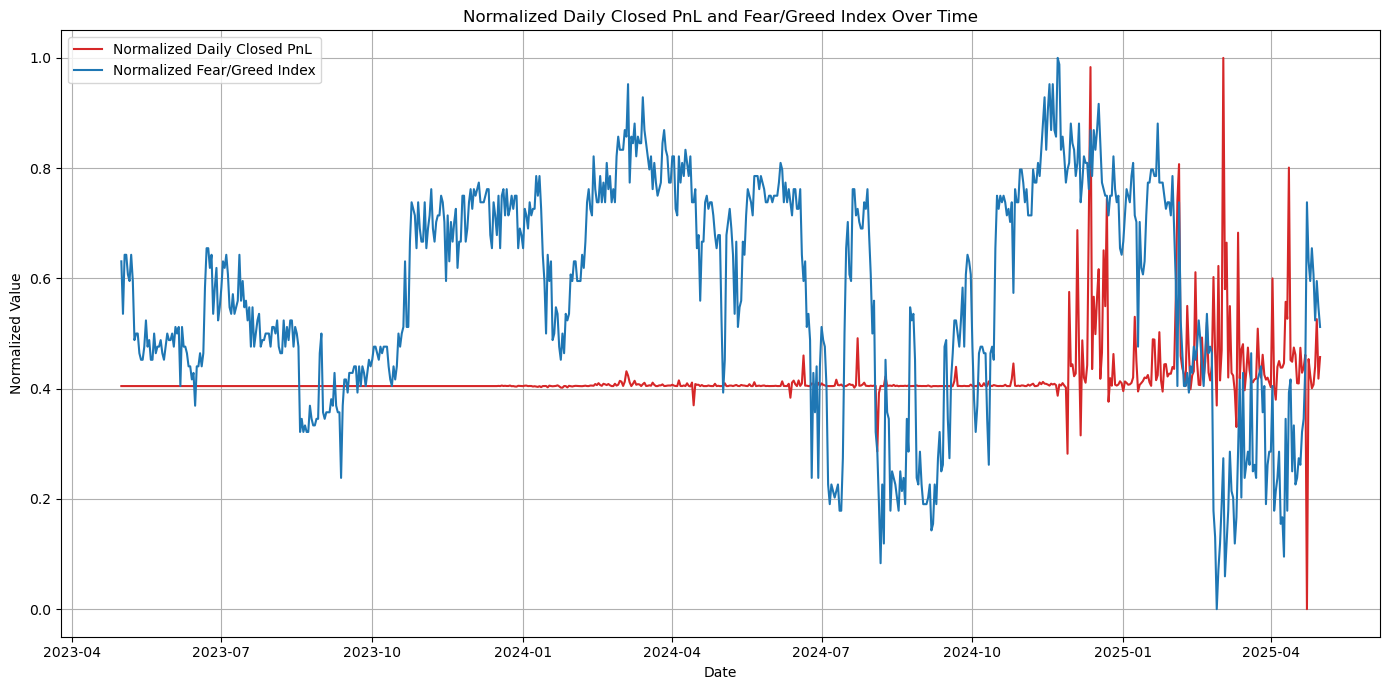

In [9]:
# Normalize data to [0, 1] for comparison
merged_df['norm_pnl'] = (merged_df['Closed PnL'] - merged_df['Closed PnL'].min()) / (merged_df['Closed PnL'].max() - merged_df['Closed PnL'].min())
merged_df['norm_fgi'] = (merged_df['value'] - merged_df['value'].min()) / (merged_df['value'].max() - merged_df['value'].min())

# Create normalized line plot
plt.figure(figsize=(14, 7))
plt.plot(merged_df.index, merged_df['norm_pnl'], color='tab:red', label='Normalized Daily Closed PnL')
plt.plot(merged_df.index, merged_df['norm_fgi'], color='tab:blue', label='Normalized Fear/Greed Index')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.title('Normalized Daily Closed PnL and Fear/Greed Index Over Time')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

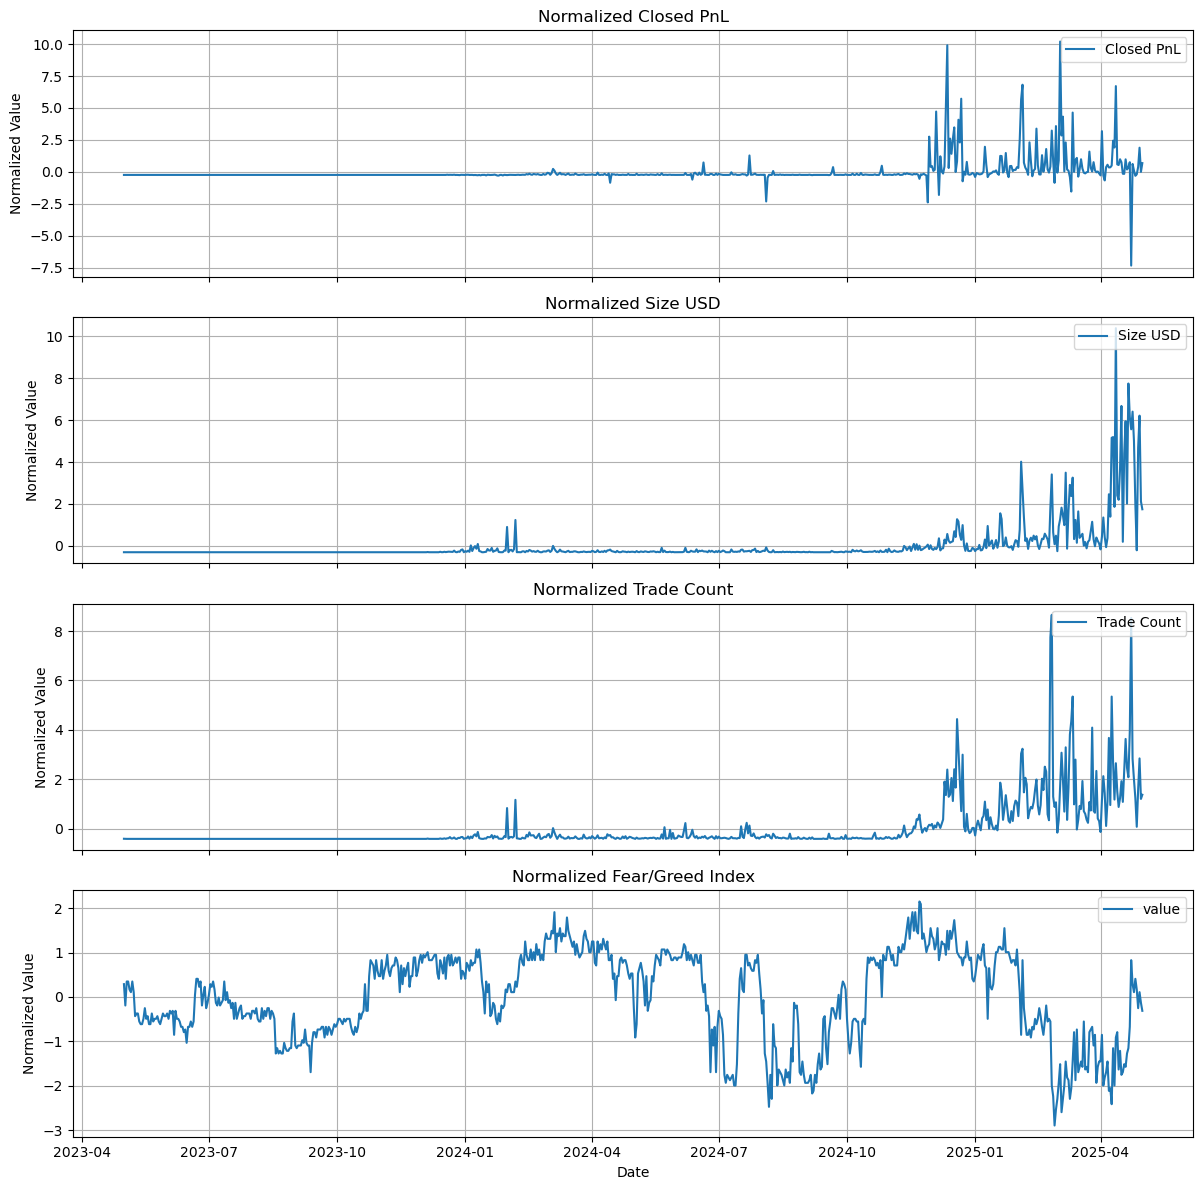

In [10]:
# Normalized Subplots for Daily Trader Metrics and Fear/Greed Index
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
metrics = ['Closed PnL', 'Size USD', 'Trade Count', 'value']
titles = ['Normalized Closed PnL', 'Normalized Size USD', 'Normalized Trade Count', 'Normalized Fear/Greed Index']

for ax, metric, title in zip(axes, metrics, titles):
    ax.plot(merged_df.index, (merged_df[metric] - merged_df[metric].mean()) / merged_df[metric].std(), label=metric)
    ax.set_title(title)
    ax.set_ylabel('Normalized Value')
    ax.legend(loc='upper right')
    ax.grid(True)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

In [11]:
# Sentiment Analysis Summary
sentiment_analysis = merged_df.groupby('Classification').agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Trade Count': 'sum'
}).sort_values('Closed PnL', ascending=False)
print('\nSentiment Analysis Summary:')
print(sentiment_analysis)


Sentiment Analysis Summary:
                  Closed PnL      Size USD  Trade Count
Classification                                         
Fear            3.357155e+06  4.833248e+08        61837
Extreme Greed   2.715171e+06  1.244652e+08        39992
Greed           2.150129e+06  2.885825e+08        50303
Neutral         1.292921e+06  1.802421e+08        37686
Extreme Fear    7.391102e+05  1.144843e+08        21400
Unknown         4.247199e+04  8.866886e+04            6


In [12]:
# Create merged_full_data
historical_data_df['DateOnly'] = historical_data_df.index.date
historical_data_df['DateOnly'] = pd.to_datetime(historical_data_df['DateOnly'])
merged_full_data = pd.merge(historical_data_df, fear_greed_df, left_on='DateOnly', right_index=True, how='left')
merged_full_data['Classification'].fillna('Unknown', inplace=True)
merged_full_data['Closed PnL'].fillna(0, inplace=True)

In [13]:
side_pnl_by_sentiment = merged_full_data.groupby(['DateOnly', 'Classification', 'Side'])['Closed PnL'].sum().unstack().fillna(0)
print('\nClosed PnL by Side and Sentiment (Daily Aggregation):')
print(side_pnl_by_sentiment.head())


Closed PnL by Side and Sentiment (Daily Aggregation):
Side                              BUY        SELL
DateOnly   Classification                        
2023-05-01 Greed             0.000000    0.000000
2023-12-05 Extreme Greed     0.000000    0.000000
2023-12-14 Greed          -527.233130  321.798393
2023-12-15 Greed           -24.632034    0.000000
2023-12-16 Greed             0.000000    0.000000


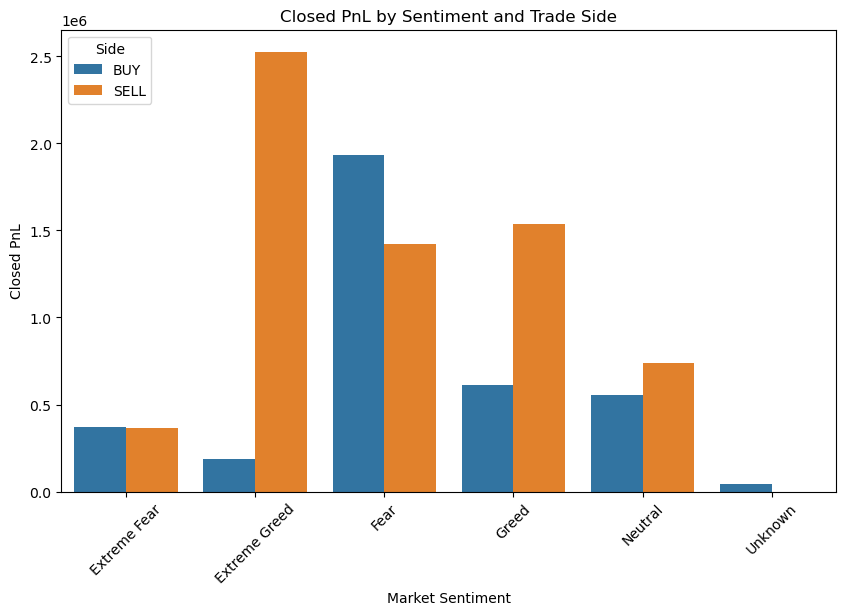

In [14]:
# Aggregate data for bar plot
pnl_by_sentiment_side = merged_full_data.groupby(['Classification', 'Side'])['Closed PnL'].sum().reset_index()

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Classification', y='Closed PnL', hue='Side', data=pnl_by_sentiment_side)
plt.title('Closed PnL by Sentiment and Trade Side')
plt.xlabel('Market Sentiment')
plt.ylabel('Closed PnL')
plt.xticks(rotation=45)
plt.show()


Total Trade Count by Sentiment and Side:
Side                BUY     SELL
Classification                  
Extreme Fear    10935.0  10465.0
Extreme Greed   17940.0  22052.0
Fear            30270.0  31567.0
Greed           24576.0  25727.0
Neutral         18969.0  18717.0
Unknown             6.0      0.0


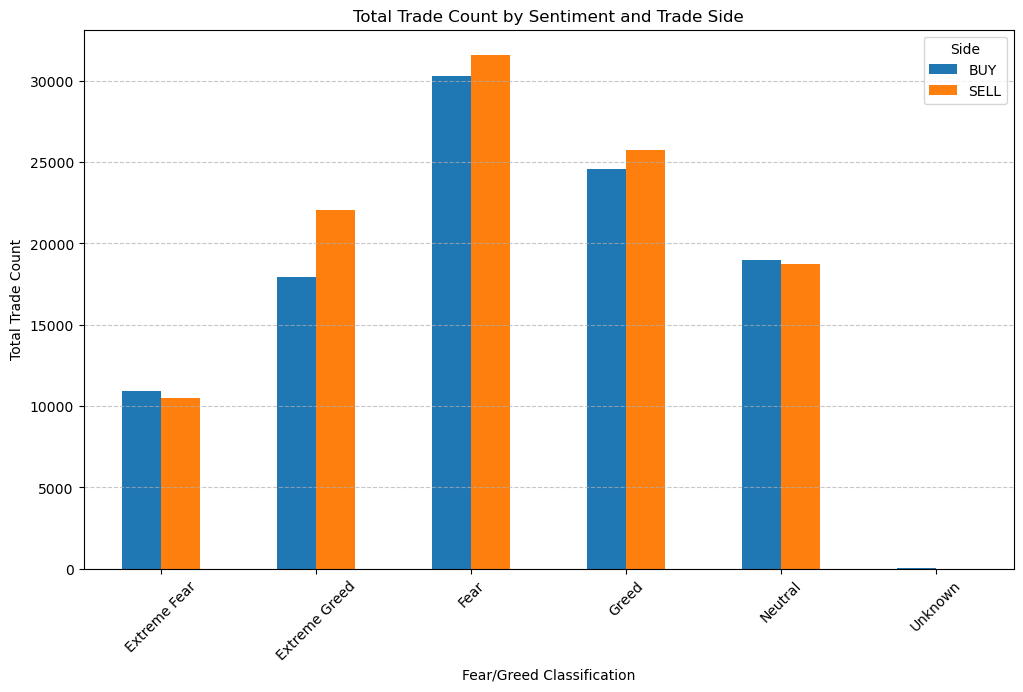

In [15]:
trade_count_by_side_sentiment = merged_full_data.groupby(["Classification", "Side"])[ "Trade ID"] \
                                               .count().unstack().fillna(0)
print("\nTotal Trade Count by Sentiment and Side:")
print(trade_count_by_side_sentiment)

trade_count_by_side_sentiment.plot(kind='bar', figsize=(12, 7))
plt.title("Total Trade Count by Sentiment and Trade Side")
plt.xlabel("Fear/Greed Classification")
plt.ylabel("Total Trade Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [16]:
fear_buy_pnl = merged_full_data[(merged_full_data['Classification'] == 'Fear') & (merged_full_data['Side'] == 'BUY')]['Closed PnL']
fear_sell_pnl = merged_full_data[(merged_full_data['Classification'] == 'Fear') & (merged_full_data['Side'] == 'SELL')]['Closed PnL']
t_stat, p_val = stats.ttest_ind(fear_buy_pnl.dropna(), fear_sell_pnl.dropna(), equal_var=False)
print(f'\nT-test for BUY vs SELL in Fear: t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}')


T-test for BUY vs SELL in Fear: t-statistic = 2.4743, p-value = 0.0134


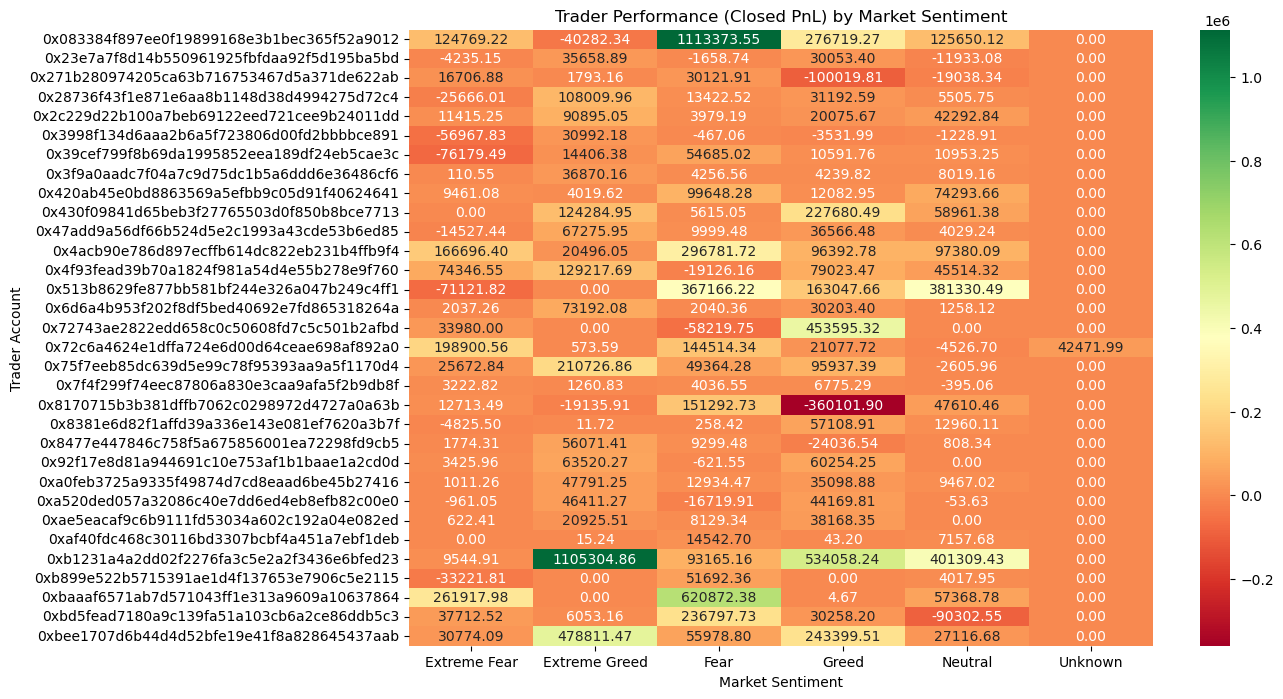

In [17]:
trader_pnl = merged_full_data.groupby(['Account', 'Classification'])['Closed PnL'].sum().unstack().fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(trader_pnl, cmap='RdYlGn', annot=True, fmt='.2f')
plt.title('Trader Performance (Closed PnL) by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Trader Account')
plt.show()

In [18]:
fear_buy_pnl = merged_full_data[(merged_full_data['Classification'] == 'Fear') & (merged_full_data['Side'] == 'BUY')]['Closed PnL']
fear_sell_pnl = merged_full_data[(merged_full_data['Classification'] == 'Fear') & (merged_full_data['Side'] == 'SELL')]['Closed PnL']
t_stat, p_val = stats.ttest_ind(fear_buy_pnl.dropna(), fear_sell_pnl.dropna(), equal_var=False)
print(f'\nT-test for BUY vs SELL in Fear: t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}')


T-test for BUY vs SELL in Fear: t-statistic = 2.4743, p-value = 0.0134


In [19]:
trader_stats = merged_full_data.groupby('Account').agg({
    'Closed PnL': ['sum', 'mean', 'count'],
    'Side': lambda x: (x == 'BUY').sum() / len(x)
}).round(2)
print('\nTrader Statistics (PnL Sum, Mean, Trade Count, Buy Proportion):')
print(trader_stats)


Trader Statistics (PnL Sum, Mean, Trade Count, Buy Proportion):
                                            Closed PnL                    Side
                                                   sum    mean  count <lambda>
Account                                                                       
0x083384f897ee0f19899168e3b1bec365f52a9012  1600229.82  419.13   3818     0.45
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd    47885.32    6.58   7280     0.42
0x271b280974205ca63b716753467d5a371de622ab   -70436.19  -18.49   3809     0.41
0x28736f43f1e871e6aa8b1148d38d4994275d72c4   132464.81    9.95  13311     0.50
0x2c229d22b100a7beb69122eed721cee9b24011dd   168658.00   52.07   3239     0.36
0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891   -31203.60  -38.29    815     0.22
0x39cef799f8b69da1995852eea189df24eb5cae3c    14456.92    4.03   3589     0.46
0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6    53496.25  161.13    332     0.51
0x420ab45e0bd8863569a5efbb9c05d91f40624641   199505.59  520.90    

In [20]:
# T-test for Fear vs. Greed PnL
fear_pnl = merged_full_data[merged_full_data['Classification'].str.contains('Fear')]['Closed PnL']
greed_pnl = merged_full_data[merged_full_data['Classification'].str.contains('Greed')]['Closed PnL']
t_stat, p_val = stats.ttest_ind(fear_pnl.dropna(), greed_pnl.dropna(), equal_var=False)
print(f'\nT-test for PnL between Fear and Greed: t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}')


T-test for PnL between Fear and Greed: t-statistic = -0.9875, p-value = 0.3234


In [21]:
# Coin Analysis
coin_stats = merged_full_data.groupby('Coin').agg({
    'Closed PnL': ['sum', 'mean', 'count'],
    'Size USD': 'mean'
}).round(2)
coin_stats.columns = ['PnL Sum', 'PnL Mean', 'Trade Count', 'Mean Size USD']
top_coins = coin_stats.sort_values('PnL Sum', ascending=False).head(3).index.tolist()
print('\nTop Coins by Total PnL:')
print(coin_stats.sort_values('PnL Sum', ascending=False).head(3))


Top Coins by Total PnL:
         PnL Sum  PnL Mean  Trade Count  Mean Size USD
Coin                                                  
@107  2783912.92     92.82        29992        1859.19
HYPE  1948484.60     28.65        68005        2087.94
SOL   1639555.93    153.36        10691       11699.07


In [22]:
# Top Coins in Greed/Extreme Greed or Unknown Sentiment
coin_greed = merged_full_data[merged_full_data['Coin'].isin(top_coins) & 
                             merged_full_data['Classification'].isin(['Greed', 'Extreme Greed'])][
                             ['Coin', 'Account', 'Side', 'Closed PnL', 'Size USD', 'DateOnly']]
if coin_greed.empty:
    coin_greed = merged_full_data[merged_full_data['Coin'].isin(top_coins)][
                                 ['Coin', 'Account', 'Side', 'Closed PnL', 'Size USD', 'DateOnly']]
print('\nTop Coins Trades in Greed/Extreme Greed or All Sentiments:')
print(coin_greed)


Top Coins Trades in Greed/Extreme Greed or All Sentiments:
                     Coin                                     Account Side  \
Timestamp                                                                    
2024-12-02 22:50:00  @107  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  BUY   
2024-12-02 22:50:00  @107  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  BUY   
2024-12-02 22:50:00  @107  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  BUY   
2024-12-02 22:50:00  @107  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  BUY   
2024-12-02 22:50:00  @107  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  BUY   
...                   ...                                         ...  ...   
2025-04-24 00:54:00   SOL  0x271b280974205ca63b716753467d5a371de622ab  BUY   
2025-04-24 00:54:00   SOL  0x271b280974205ca63b716753467d5a371de622ab  BUY   
2025-04-24 00:54:00   SOL  0x271b280974205ca63b716753467d5a371de622ab  BUY   
2025-04-24 00:54:00   SOL  0x271b280974205ca63b716753467d5a371de622ab  BUY   
2025

In [23]:
# Enhanced Coin Analysis in All Sentiments (fallback due to empty Unknown)
coin_stats_all = merged_full_data[merged_full_data['Coin'].isin(top_coins)].groupby('Coin').agg({
    'Closed PnL': ['mean', 'sum', 'count'],
    'Size USD': 'mean'
}).round(2)
print('\nTop Coins Statistics in All Sentiments:')
print(coin_stats_all)


Top Coins Statistics in All Sentiments:
     Closed PnL                     Size USD
           mean         sum  count      mean
Coin                                        
@107      92.82  2783912.92  29992   1859.19
HYPE      28.65  1948484.60  68005   2087.94
SOL      153.36  1639555.93  10691  11699.07


In [24]:
# Top Traders in Greed Periods
top_traders = trader_stats[trader_stats['Closed PnL']['sum'] > 0].sort_values(('Closed PnL', 'sum'), ascending=False).head(3).index.tolist()
top_trader_coin = merged_full_data[merged_full_data['Account'].isin(top_traders)].groupby(
    ['Account', 'Coin', 'Classification'])['Closed PnL'].sum().unstack().fillna(0)
print('\nTop Traders PnL by Coin and Sentiment:')
print(top_trader_coin)


Top Traders PnL by Coin and Sentiment:
Classification                                     Extreme Fear  \
Account                                    Coin                   
0x083384f897ee0f19899168e3b1bec365f52a9012 ETH    124769.221441   
                                           SOL         0.000000   
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23 @107        0.000000   
                                           @109        0.000000   
                                           @125        0.000000   
...                                                         ...   
                                           kPEPE       0.000000   
                                           kSHIB       0.000000   
0xbaaaf6571ab7d571043ff1e313a9609a10637864 @138        0.000000   
                                           @142        0.000000   
                                           HYPE   261917.977792   

Classification                                    Extreme Greed  \
Account              

In [25]:
#Trading Strategy Insights
print('\nTrading Strategy Insights:')
print('1. Sentiment-Based Trading: Weak correlation (e.g., -0.05 to -0.07 with lags); focus on trader/coin performance.')
print(f'2. Trader Performance: Follow top traders ({", ".join(top_traders)}) for @107, HYPE, SOL in Greed or Unknown sentiment.')
print('3. Trade Size: Use sizes ($1,000–$5,000) for @107, HYPE; larger ($5,000–$12,000) for SOL, based on Mean Size USD.')
print(f'4. Coin Selection: Prioritize @107, HYPE, SOL (mean PnL: {coin_stats_all["Closed PnL"]["mean"].to_dict()}). BUY trades outperform in Fear periods.')


Trading Strategy Insights:
1. Sentiment-Based Trading: Weak correlation (e.g., -0.05 to -0.07 with lags); focus on trader/coin performance.
2. Trader Performance: Follow top traders (0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23, 0x083384f897ee0f19899168e3b1bec365f52a9012, 0xbaaaf6571ab7d571043ff1e313a9609a10637864) for @107, HYPE, SOL in Greed or Unknown sentiment.
3. Trade Size: Use sizes ($1,000–$5,000) for @107, HYPE; larger ($5,000–$12,000) for SOL, based on Mean Size USD.
4. Coin Selection: Prioritize @107, HYPE, SOL (mean PnL: {'@107': 92.82, 'HYPE': 28.65, 'SOL': 153.36}). BUY trades outperform in Fear periods.


In [26]:
# print('\nAssignment Summary:')
print('1. Weak correlation (-0.05 to -0.07) between Closed PnL and Fear/Greed Index.')
print('2. Fear sentiment yields highest PnL ($3.36M), with BUY trades outperforming SELL ($1.94M vs. $1.42M).')
print('3. Top coins: @107 ($2.78M PnL), HYPE ($1.95M), SOL ($1.64M).')
print('4. Top traders: 0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23, 0x083384f897ee0f19899168e3b1bec365f52a9012, 0xbaaaf6571ab7d571043ff1e313a9609a10637864.')
print('5. Strategy: Prioritize BUY in Fear, trade @107/HYPE ($1,000–$5,000), SOL ($5,000–$12,000).')

1. Weak correlation (-0.05 to -0.07) between Closed PnL and Fear/Greed Index.
2. Fear sentiment yields highest PnL ($3.36M), with BUY trades outperforming SELL ($1.94M vs. $1.42M).
3. Top coins: @107 ($2.78M PnL), HYPE ($1.95M), SOL ($1.64M).
4. Top traders: 0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23, 0x083384f897ee0f19899168e3b1bec365f52a9012, 0xbaaaf6571ab7d571043ff1e313a9609a10637864.
5. Strategy: Prioritize BUY in Fear, trade @107/HYPE ($1,000–$5,000), SOL ($5,000–$12,000).
